In [151]:
# NecessaryImports
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import LdaModel
from gensim import corpora, models
from gensim.corpora.dictionary import Dictionary

from wordcloud import WordCloud
import nltk 
from nltk import FreqDist
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer, SnowballStemmer


In [ ]:
df = pd.read_csv('IMDB new Dataset.csv') # load the CSV file
df

,Unnamed: 0,class,text
0,0,positive,One of the other reviewers has mentioned that ...
1,1,positive,A wonderful little production. <br /><br />The...
2,2,positive,I thought this was a wonderful way to spend ti...
3,3,negative,Basically there's a family where a little boy ...
4,4,positive,"Petter Mattei's ""Love in the Time of Money"" is..."
...,...,...,...
49995,49995,positive,I thought this movie did a down right good job...
49996,49996,negative,"Bad plot, bad dialogue, bad acting, idiotic di..."
49997,49997,negative,I am a Catholic taught in parochial elementary...
49998,49998,negative,I'm going to have to disagree with the previou...


In [153]:
df = df.iloc[:,1:] #making minor changes to dataset
df

,class,text
0,positive,One of the other reviewers has mentioned that ...
1,positive,A wonderful little production. <br /><br />The...
2,positive,I thought this was a wonderful way to spend ti...
3,negative,Basically there's a family where a little boy ...
4,positive,"Petter Mattei's ""Love in the Time of Money"" is..."
...,...,...
49995,positive,I thought this movie did a down right good job...
49996,negative,"Bad plot, bad dialogue, bad acting, idiotic di..."
49997,negative,I am a Catholic taught in parochial elementary...
49998,negative,I'm going to have to disagree with the previou...


## Visualizing Sentiment Distribution

           text
class          
negative  25000
positive  25000


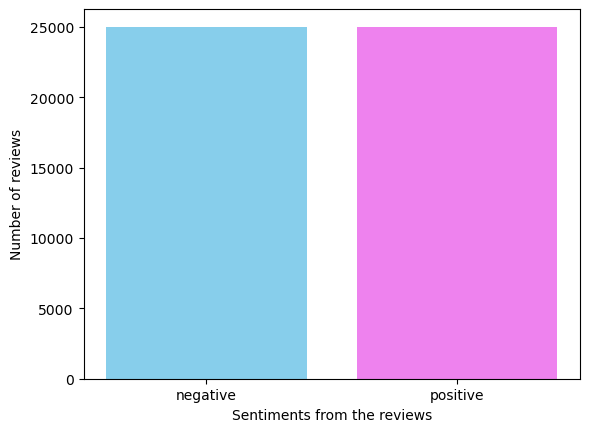

In [154]:
np.random.seed(500)

class_count = df.groupby('class').count()
print(class_count)

colors = ['skyblue', 'violet']
plt.bar(class_count.index.values, class_count['text'], color= colors) # Counting numberofreviews in each sentiment class
plt.xlabel('Sentiments from the reviews')
plt.ylabel('Number of reviews')
plt.show()

## Preprocessing Text

#### Removing numbers, conversion of text into lower case, replacing punctuations with white space.

In [155]:
import re

df['text'] = [re.sub(r'<.*?>', '', i) for i in df['text']] # Removing HTML tags from the text reviews

df['text']=[re.sub('\d','', i)for i in df['text']] # Removing HTML tags from the text reviews

import string
df['text']=[re.sub('[%s]' % re.escape(string.punctuation), ' ', i) for i in df['text']] # Removing punctuation from the text reviews

df['text']=[i.lower() for i in df['text']]
df.head(15)

<>:5: DeprecationWarning: invalid escape sequence \d
<>:5: DeprecationWarning: invalid escape sequence \d
C:\Users\Zikai\AppData\Local\Temp\ipykernel_39396\2111230282.py:5: DeprecationWarning: invalid escape sequence \d
  df['text']=[re.sub('\d','', i)for i in df['text']]


,class,text
0,positive,one of the other reviewers has mentioned that ...
1,positive,a wonderful little production the filming tec...
2,positive,i thought this was a wonderful way to spend ti...
3,negative,basically there s a family where a little boy ...
4,positive,petter mattei s love in the time of money is...
5,positive,probably my all time favorite movie a story o...
6,positive,i sure would like to see a resurrection of a u...
7,negative,this show was an amazing fresh innovative i...
8,negative,encouraged by the positive comments about this...
9,positive,if you like original gut wrenching laughter yo...


#### Tokenization

In [156]:
from nltk.tokenize import word_tokenize
df['tokenize_text'] = [word_tokenize(i) for i in df['text']]  # Tokenizing the text reviews into words
df.head()

,class,text,tokenize_text
0,positive,one of the other reviewers has mentioned that ...,"[one, of, the, other, reviewers, has, mentione..."
1,positive,a wonderful little production the filming tec...,"[a, wonderful, little, production, the, filmin..."
2,positive,i thought this was a wonderful way to spend ti...,"[i, thought, this, was, a, wonderful, way, to,..."
3,negative,basically there s a family where a little boy ...,"[basically, there, s, a, family, where, a, lit..."
4,positive,petter mattei s love in the time of money is...,"[petter, mattei, s, love, in, the, time, of, m..."


#### Stopword removal

In [157]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

df['stopwordd_text'] = [[i for i in j if not i in stop_words] for j in df['tokenize_text']]  # Removing stop words (common words like "the", "a", "an")
df.head()

,class,text,tokenize_text,stopwordd_text
0,positive,one of the other reviewers has mentioned that ...,"[one, of, the, other, reviewers, has, mentione...","[one, reviewers, mentioned, watching, oz, epis..."
1,positive,a wonderful little production the filming tec...,"[a, wonderful, little, production, the, filmin...","[wonderful, little, production, filming, techn..."
2,positive,i thought this was a wonderful way to spend ti...,"[i, thought, this, was, a, wonderful, way, to,...","[thought, wonderful, way, spend, time, hot, su..."
3,negative,basically there s a family where a little boy ...,"[basically, there, s, a, family, where, a, lit...","[basically, family, little, boy, jake, thinks,..."
4,positive,petter mattei s love in the time of money is...,"[petter, mattei, s, love, in, the, time, of, m...","[petter, mattei, love, time, money, visually, ..."


#### Lemmatization

In [158]:
from collections import defaultdict 
from nltk.corpus import wordnet as wn 
from nltk.tag import pos_tag

tag_map = defaultdict(lambda : wn.NOUN)  
tag_map['J'] = wn.ADJ                   
tag_map['V'] = wn.VERB                  

lemmatizer = WordNetLemmatizer() # Lemmatization: convert words to their base form (e.g., "running" -> "run")
df['lemmatized_words']=[[lemmatizer.lemmatize(word,tag_map[tag[0]]) for word ,tag in pos_tag(i)] for i in df['stopwordd_text']] 
df.head()

,class,text,tokenize_text,stopwordd_text,lemmatized_words
0,positive,one of the other reviewers has mentioned that ...,"[one, of, the, other, reviewers, has, mentione...","[one, reviewers, mentioned, watching, oz, epis...","[one, reviewer, mention, watch, oz, episode, h..."
1,positive,a wonderful little production the filming tec...,"[a, wonderful, little, production, the, filmin...","[wonderful, little, production, filming, techn...","[wonderful, little, production, film, techniqu..."
2,positive,i thought this was a wonderful way to spend ti...,"[i, thought, this, was, a, wonderful, way, to,...","[thought, wonderful, way, spend, time, hot, su...","[think, wonderful, way, spend, time, hot, summ..."
3,negative,basically there s a family where a little boy ...,"[basically, there, s, a, family, where, a, lit...","[basically, family, little, boy, jake, thinks,...","[basically, family, little, boy, jake, think, ..."
4,positive,petter mattei s love in the time of money is...,"[petter, mattei, s, love, in, the, time, of, m...","[petter, mattei, love, time, money, visually, ...","[petter, mattei, love, time, money, visually, ..."


In [159]:
df['lemma2'] = df['lemmatized_words'].apply(lambda x:' '.join(x))  # Combining lemmatized words back into sentences
df['lemma2'].head()

0    one reviewer mention watch oz episode hook rig...
1    wonderful little production film technique una...
2    think wonderful way spend time hot summer week...
3    basically family little boy jake think zombie ...
4    petter mattei love time money visually stunnin...
Name: lemma2, dtype: object

### Bigram and Trigram modelling

In [160]:
from gensim.models import Phrases
from gensim.models.phrases import Phraser

bigram = Phrases(df['lemmatized_words'], min_count=5, threshold=100) 
trigram = Phrases(bigram[df['lemmatized_words']], threshold=100)  # Bigram and Trigram detection (optional) - consider words that frequently appear together (e.g., "machine learning")

bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

# Trigram models
df['lemmatized_words'] = [trigram_mod[doc] for doc in df['lemmatized_words']]

print(df['lemmatized_words'].head())


0    [one, reviewer, mention, watch, oz, episode, h...
1    [wonderful, little, production, film, techniqu...
2    [think, wonderful, way, spend, time, hot, summ...
3    [basically, family, little, boy, jake, think, ...
4    [petter, mattei, love, time, money, visually_s...
Name: lemmatized_words, dtype: object


## Frequency Analysis

In [161]:
# function to plot most frequent terms
def freq_words(x, terms = 20):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    df_words = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
    
      # selecting top 20 most frequent words
    d = df_words.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()
    

#### Plotting most frequent terms in a graph

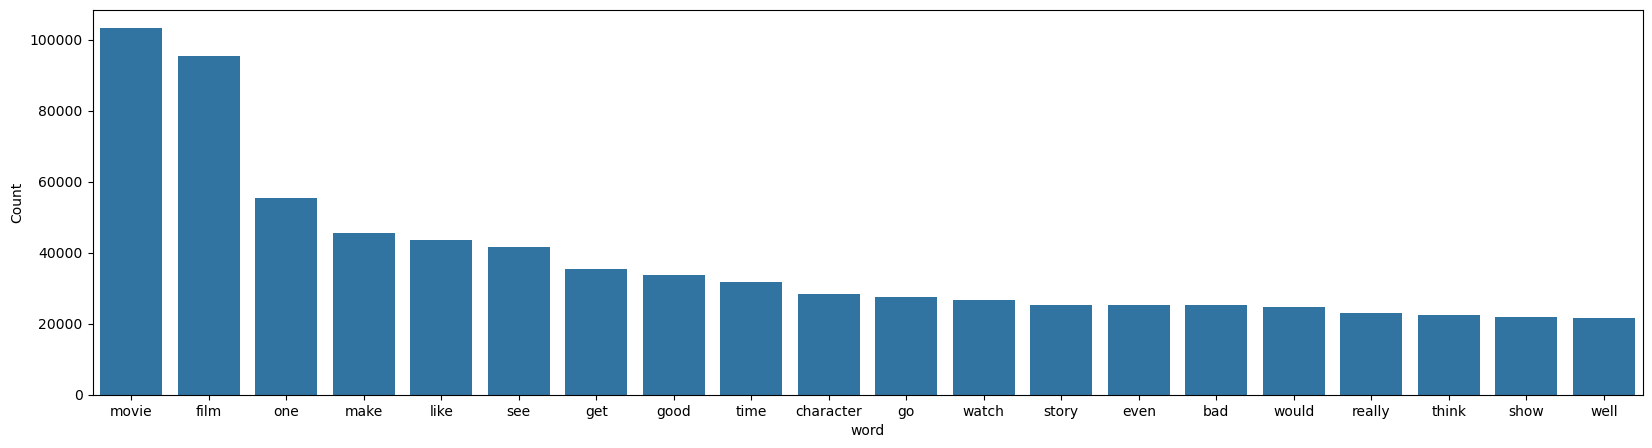

In [162]:
freq_words(df['lemma2'])

#### In a Wordcloud

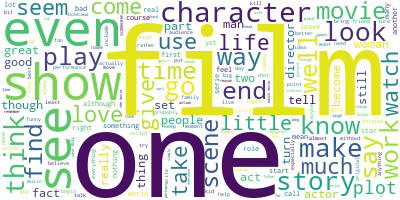

In [163]:
long_string = ','.join(list(df['lemma2'].values))

wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='red')
wordcloud.generate(long_string)
wordcloud.to_image()

## Preparing Data for LDA

#### creating Dictionary

In [164]:
id2word = corpora.Dictionary(df["lemmatized_words"]) # Creating a dictionary for mapping words to their integer IDs

#### creating Corpus

In [165]:
texts = df['lemmatized_words']

#### terming document frequency

In [166]:
corpus = [id2word.doc2bow(text) for text in texts]  # Convert preprocessed text into a document-term matrix
corpus

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 2),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 2),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 2),
  (26, 1),
  (27, 1),
  (28, 2),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 2),
  (38, 1),
  (39, 3),
  (40, 1),
  (41, 1),
  (42, 3),
  (43, 1),
  (44, 1),
  (45, 2),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 2),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 2),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1),
  (80, 6),
  (81, 1),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 2),
  (86, 1),
  (87, 1),
  (88, 1),
  (89, 1),
  (90, 1),
  (91, 1)

## Creating the Topic Model

In [167]:
# Training the LDA model with specified perimeters & printing the topics discovered by the LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word, num_topics=8, random_state=100, update_every=1, chunksize=100, passes=12, alpha='auto', per_word_topics=True)

lda_model.print_topics()




[(0,
  '0.095*"film" + 0.010*"make" + 0.009*"director" + 0.007*"work" + 0.006*"use" + 0.005*"may" + 0.005*"audience" + 0.005*"many" + 0.004*"viewer" + 0.004*"point"'),
 (1,
  '0.028*"character" + 0.025*"story" + 0.019*"great" + 0.019*"one" + 0.018*"well" + 0.017*"also" + 0.016*"play" + 0.012*"best" + 0.010*"love" + 0.009*"actor"'),
 (2,
  '0.032*"catch" + 0.029*"town" + 0.022*"high_school" + 0.018*"western" + 0.013*"wow" + 0.011*"lesson" + 0.011*"joe" + 0.011*"japan" + 0.010*"green" + 0.010*"outstanding"'),
 (3,
  '0.052*"movie" + 0.022*"like" + 0.021*"see" + 0.018*"get" + 0.018*"make" + 0.016*"one" + 0.014*"watch" + 0.013*"bad" + 0.013*"go" + 0.012*"good"'),
 (4,
  '0.114*"show" + 0.045*"series" + 0.031*"episode" + 0.025*"song" + 0.021*"tv" + 0.017*"dance" + 0.014*"voice" + 0.013*"season" + 0.012*"television" + 0.011*"musical"'),
 (5,
  '0.031*"horror" + 0.011*"game" + 0.010*"original" + 0.010*"evil" + 0.010*"kill" + 0.009*"effect" + 0.009*"monster" + 0.009*"blood" + 0.008*"house" + 0

#### Calculating performance metrics

In [168]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # Calculate perplexity: a measure of how well the model fits the data

coherence_model_lda = CoherenceModel(model=lda_model, texts=df["lemmatized_words"], dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence() # Calculate coherence score: a measure of how semantically related words are within a topic
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.616840471033413

Coherence Score:  0.36242587056371045


In [169]:
pyLDAvis.enable_notebook() # Interactive topic visualization
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.254571  0.034593       1        1  36.135939
1      0.227577  0.091895       2        1  19.438680
0      0.174991  0.051503       3        1  18.649838
7      0.109682 -0.115059       4        1  13.048879
6     -0.136526 -0.276578       5        1   4.614540
5     -0.147766 -0.162338       6        1   4.375595
4     -0.223223  0.267008       7        1   2.639889
2     -0.259307  0.108976       8        1   1.096642, topic_info=           Term           Freq          Total Category  logprob  loglift
148        film  100543.000000  100543.000000  Default  30.0000  30.0000
274       movie  107600.000000  107600.000000  Default  29.0000  29.0000
104        show   22908.000000   22908.000000  Default  28.0000  28.0000
198   character   30761.000000   30761.000000  Default  27.0000  27.0000
271        like   46132.000000   46132.000000  Default  26.0000  26.0000
...         ...            ...            ...      ...      ...      ...
6850        jam     296.622633     297.539515   Topic8  -5.3501   4.5098
9436     wilson     291.280497     292.197008   Topic8  -5.3683   4.5098
5384     bottle     288.518948     289.436213   Topic8  -5.3778   4.5097
7064   sadistic     283.873803     284.790414   Topic8  -5.3940   4.5097
7355         al     282.389747     283.306194   Topic8  -5.3993   4.5097

[411 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2437      3  0.999338  ability
291       1  0.843303      act
291       2  0.156640      act
128       1  0.252019    actor
128       2  0.747950    actor
...     ...       ...      ...
1817      2  0.152898      yet
1817      3  0.708297      yet
252       4  0.999928    young
290       6  0.999324   zombie
4887      5  0.999683        

[574 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 1, 8, 7, 6, 5, 3])

## Naming Topics

In [170]:
# Function to get the top words for each topi
def get_top_words_for_topic(model, num_topics=8, num_words=10):
    topic_names = {}
    for topic_id in range(num_topics):
        top_words = model.show_topic(topic_id, num_words)
        words = [word for word, _ in top_words]
        topic_names[topic_id] = " ".join(words)
    return topic_names


    # This function retrieves the top 'num_words' words for each of the 'num_topics' discovered by the LDA model.

    # Args:
    #     model (gensim.LdaModel): The trained LDA model.
    #     num_topics (int, optional): The number of topics. Defaults to 8.
    #     num_words (int, optional): The number of top words to retrieve for each topic. Defaults to 10.

    # Returns:
    #     dict: A dictionary where keys are topic IDs and values are lists of top words for each topic.
    
topic_names = get_top_words_for_topic(lda_model, num_topics=8, num_words=10)
print("Topic Names Based on Top Words:")
for topic_id, topic_name in topic_names.items():
    print(f"Topic {topic_id + 1}: {topic_name}")

Topic Names Based on Top Words:
Topic 1: film make director work use may audience many viewer point
Topic 2: character story great one well also play best love actor
Topic 3: catch town high_school western wow lesson joe japan green outstanding
Topic 4: movie like see get make one watch bad go good
Topic 5: show series episode song tv dance voice season television musical
Topic 6: horror game original evil kill effect monster blood house imagine
Topic 7: kill murder  car hero run cop fight victim fire
Topic 8: life man year woman young live family old take child


In [ ]:
topic_names = {
    0: "Filmmaking & Audience Engagement",
    1: "Acting & Character Performance",
    2: "Diverse/Eclectic Films",
    3: "General Movie Viewing Experience",
    4: "Television & Musical Entertainment",
    5: "Horror & Monster Films",
    6: "Action & Crime Films",
    7: "Life, Family & Age"
}

# Create a dictionary to store topic names and their corresponding top words
topics_with_names = {}
for topic_id in range(lda_model.num_topics):
    top_words = lda_model.show_topic(topic_id, 10)
    words = [word for word, _ in top_words]
    topic_name = topic_names.get(topic_id, "Unknown Topic")  
    topics_with_names[topic_name] = words


for topic_name, words in topics_with_names.items():
    print(f"Topic: {topic_name}\nWords: {', '.join(words)}\n")

Topic: Filmmaking & Audience Engagement
Words: film, make, director, work, use, may, audience, many, viewer, point

Topic: Acting & Character Performance
Words: character, story, great, one, well, also, play, best, love, actor

Topic: Diverse/Eclectic Films
Words: catch, town, high_school, western, wow, lesson, joe, japan, green, outstanding

Topic: General Movie Viewing Experience
Words: movie, like, see, get, make, one, watch, bad, go, good

Topic: Television & Musical Entertainment
Words: show, series, episode, song, tv, dance, voice, season, television, musical

Topic: Horror & Monster Films
Words: horror, game, original, evil, kill, effect, monster, blood, house, imagine

Topic: Action & Crime Films
Words: kill, murder, , car, hero, run, cop, fight, victim, fire

Topic: Life, Family & Age
Words: life, man, year, woman, young, live, family, old, take, child



In [172]:
import pickle

# Save the model to a .pkl file
with open('lda_model_three.pkl', 'wb') as file:
    pickle.dump(lda_model, file)

In [173]:
from gensim.corpora import Dictionary
id2word.save('id2word_three.dict')